In [1]:
# 结构信息

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [3]:
# 得到P
acc=pd.read_csv("../data/地震加速度.csv")  # m/s^2
acc=acc.iloc[1,1:].values
ag=acc
n = ag.shape[0]
dt=0.02

In [4]:
m = torch.tensor([5000.0, 5000.0, 5000.0, 5000.0, 5000.0])   ##单位：kg
M = torch.diag(m)

In [5]:
#定义初始刚度，单位：N/m
k = torch.tensor([1e7, 1e7, 1e7, 1e7, 1e7]) 
K = torch.tensor([[k[0]+k[1],-k[1],0,0,0],
                [-k[1],k[1]+k[2],-k[2],0,0],
                [0,-k[2],k[2]+k[3],-k[3],0],
                [0,0,-k[2],k[3]+k[4],-k[4]],
                [0,0,0,-k[4],k[4]]])

In [6]:
zeta = 0.03; w1 = 0.4479; w2 = 1.16   #定义结构阻尼比，1、2阶频率 9层
a_coe = 2*w1*w2*zeta/(w1+w2); b_coe = 2*zeta/(w1+w2)
C =a_coe*M + b_coe*K  #计算瑞利阻尼

In [7]:
dofs = M.shape[0]   #自由度个数

In [8]:
#定义、计算积分常数
beta = 0.25
gama = 0.5
a0 = (1 / beta / dt / dt)
a1 = (gama / beta / dt)
a2 = (1 / beta / dt)
a3 = (1 / 2 / beta - 1)
a4 = (gama / beta - 1)
a5 = (dt / 2 * (gama / beta - 2))
a6 = (dt * (1 - gama))
a7 = (dt * gama)

In [9]:
#形成等效刚度矩阵,建立结构运动状态0矩阵
n=len(acc)
u = torch.zeros((dofs, n))   
v = torch.zeros((dofs, n))
acc = torch.zeros((dofs, n))
du = torch.zeros((dofs, n))   #定义位移增量

In [10]:
#增量方程形式逐步积分
for i in range(1, n):
    dPP = -(ag[i] - ag[i - 1]) * m + M@(a2 * v[:, i - 1] + (a3 + 1) * acc[:, i - 1]) + C@((a4 + 1) * v[:, i - 1] + a5 * acc[:, i - 1])
    KK = torch.tensor([
                    [k[0]+k[1],-k[1],0,0,0],
                    [-k[1],k[1]+k[2],-k[2],0,0],
                    [0,-k[2],k[2]+k[3],-k[3],0],
                    [0,0,-k[2],k[3]+k[4],-k[4]],
                    [0,0,0,-k[4],k[4]]
                  ])
    K_hat = KK + a0 * M + a1 * C          #形成相对刚度矩阵
    K_hat_inv = torch.linalg.inv(K_hat)
    du[:, i] = K_hat_inv@dPP     #相对刚度矩阵的逆与 外力变化值点乘  得到 位移变化值
    u[:, i] = u[:, i - 1] + du[:, i]      #得到本时间步结束时的总位移
    acc[:, i] = a0 * du[:, i] - a2 * v[:, i - 1] - a3 * acc[:, i - 1]       #计算加速度
    v[:, i] = a1 * du[:, i] - a4 * v[:, i - 1] - a5 * acc[:, i - 1]         #计算速度


In [11]:
u.shape

torch.Size([5, 1500])

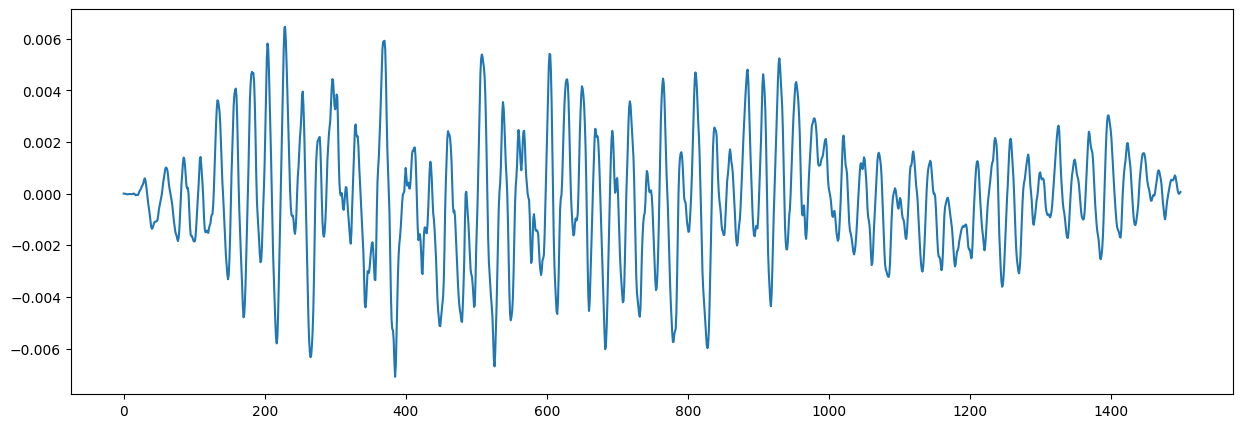

In [12]:
plt.figure(figsize=(15,5))
plt.plot(range(1500),u[0,:])